In [30]:
!pip install pandas numpy torch transformers scikit-learn

## Trying CNN for the feature extraction and using that data for the training in the lstm

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

class Stock_Price_Forecasting_LSTM:
    def __init__(self, stock_data_path):
        self.stock_data = pd.read_csv(stock_data_path)
        print(self.stock_data.head())
        self.min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        self.X_training_data = None
        self.X_testing_data = None
        self.y_training_data = None
        self.y_test_data = None
        self.lstm_model = None

    def stock_data_cleaning(self, time_steps):
        self.stock_data['Date'] = pd.to_datetime(self.stock_data['Date'])
        self.stock_data.sort_values('Date', inplace=True)
        daily_closing_price = self.stock_data['Close'].values.reshape(-1, 1)
        scaled_daily_closing_price = self.min_max_scaler.fit_transform(daily_closing_price)
        X_data, y_data = self.load_stock_dataset(scaled_daily_closing_price, time_steps)
        X_data = X_data.reshape(X_data.shape[0], X_data.shape[1], 1)
        train_size = int(len(X_data) * 0.97)
        self.X_training_data, self.X_testing_data = X_data[:train_size], X_data[train_size:]
        self.y_training_data, self.y_test_data = y_data[:train_size], y_data[train_size:]
        print("After cleaning X training data"+str(self.X_training_data))

    def load_stock_dataset(self, data, time_steps):
        X_data, y_data = [], []
        for i in range(len(data) - time_steps):
            X_data.append(data[i:(i + time_steps), 0])
            y_data.append(data[i + time_steps, 0])
        return np.array(X_data), np.array(y_data)

    def lstm_stock_model(self):
        lstm_model = Sequential()
        lstm_model.add(LSTM(units=132, return_sequences=True, input_shape=(self.X_training_data.shape[1], 1)))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(LSTM(units=110, return_sequences=False))
        lstm_model.add(Dropout(0.2))
        lstm_model.add(Dense(units=1))
        lstm_model.compile(optimizer='adam', loss='mean_squared_error')
        self.lstm_model = lstm_model
        print(self.lstm_model.summary())

    def lstm_model_training(self, epochs=80, batch_size=16, validation_split=0.1):
        lstm_stock_market_trained_model = self.lstm_model.fit(self.X_training_data, self.y_training_data, epochs=epochs, batch_size=batch_size, validation_split=validation_split)
        return lstm_stock_market_trained_model

    def rsme_mae(self):
        lstm_train_prediction = self.lstm_model.predict(self.X_training_data)
        lstm_test_predictions = self.lstm_model.predict(self.X_testing_data)
        lstm_train_prediction = self.min_max_scaler.inverse_transform(lstm_train_prediction)
        y_training_data = self.min_max_scaler.inverse_transform([self.y_training_data])
        lstm_test_predictions = self.min_max_scaler.inverse_transform(lstm_test_predictions)
        y_test_data = self.min_max_scaler.inverse_transform([self.y_test_data])

        trianed_data_rsme_result = np.sqrt(mean_squared_error(y_training_data[0], lstm_train_prediction[:, 0]))
        test_data_rsme_result = np.sqrt(mean_squared_error(y_test_data[0], lstm_test_predictions[:, 0]))
        trianed_data_mae_result = mean_absolute_error(y_training_data[0], lstm_train_prediction[:, 0])
        tested_data_mae_result = mean_absolute_error(y_test_data[0], lstm_test_predictions[:, 0])

        return trianed_data_rsme_result, test_data_rsme_result, trianed_data_mae_result, tested_data_mae_result, y_training_data[0], lstm_train_prediction[:, 0], y_test_data[0], lstm_test_predictions[:, 0]

    def graph_training_loss_validation_loss(self, lstm_predicted_stock):
        plt.plot(lstm_predicted_stock.history['loss'], label='Training Loss')
        plt.plot(lstm_predicted_stock.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss and Validation Loss after training')
        plt.legend()
        plt.show()

    def lstm_stock_market_forecasting_plot(self, test_actual, test_predicted):
        plt.figure(figsize=(12, 6))
        plt.plot(self.stock_data['Date'][-len(test_actual):], test_actual, label='Actual Test plot')
        plt.plot(self.stock_data['Date'][-len(test_predicted):], test_predicted, label='Predicted Test plot')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Prediction and Actual plot')
        plt.legend()
        plt.show()

    def five_year_stock_price_plot(self, test_actual, test_predicted):
        plt.figure(figsize=(12, 6))
        plt.plot(self.stock_data['Date'][-(5 * 365):], self.stock_data['Close'][-(5 * 365):], label='Stock Prices of Last 5 years')
        plt.plot(self.stock_data['Date'][-len(test_actual):], test_actual, label='Actual Test Plot')
        plt.plot(self.stock_data['Date'][-len(test_predicted):], test_predicted, label='Predicted Test Plot')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.title('Stock Market Forecasting')
        plt.legend()
        plt.show()

stock_forecaster = Stock_Price_Forecasting_LSTM('UBER.csv')

         Date       Open       High        Low      Close  Adj Close  \
0  2019-05-10  42.000000  45.000000  41.060001  41.570000  41.570000   
1  2019-05-13  38.790001  39.240002  36.080002  37.099998  37.099998   
2  2019-05-14  38.310001  39.959999  36.849998  39.959999  39.959999   
3  2019-05-15  39.369999  41.880001  38.950001  41.290001  41.290001   
4  2019-05-16  41.480000  44.060001  41.250000  43.000000  43.000000   

      Volume  
0  186322500  
1   79442400  
2   46661100  
3   36086100  
4   38115500  


In [32]:
stock_forecaster.stock_data_cleaning(time_steps=60)

After cleaning X training data[[[0.47103362]
  [0.39232255]
  [0.44268355]
  ...
  [0.46645537]
  [0.45043144]
  [0.4266596 ]]

 [[0.39232255]
  [0.44268355]
  [0.4661032 ]
  ...
  [0.45043144]
  [0.4266596 ]
  [0.42842052]]

 [[0.44268355]
  [0.4661032 ]
  [0.49621411]
  ...
  [0.4266596 ]
  [0.42842052]
  [0.43810531]]

 ...

 [[0.52984679]
  [0.51857721]
  [0.53389679]
  ...
  [0.83958442]
  [0.82831485]
  [0.82602569]]

 [[0.51857721]
  [0.53389679]
  [0.55150552]
  ...
  [0.82831485]
  [0.82602569]
  [0.83289308]]

 [[0.53389679]
  [0.55150552]
  [0.54886426]
  ...
  [0.82602569]
  [0.83289308]
  [0.80753652]]]


In [33]:
stock_forecaster.lstm_stock_model()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 60, 132)           70752     
                                                                 
 dropout_18 (Dropout)        (None, 60, 132)           0         
                                                                 
 lstm_19 (LSTM)              (None, 110)               106920    
                                                                 
 dropout_19 (Dropout)        (None, 110)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 111       
                                                                 
Total params: 177783 (694.46 KB)
Trainable params: 177783 (694.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [34]:
lstm_predicted_stock = stock_forecaster.lstm_model_training(epochs=110, batch_size=16, validation_split=0.1)

Epoch 1/110
63/63 [==============================] - 10s 56ms/step - loss: 0.0094 - val_loss: 0.0044
Epoch 2/110
63/63 [==============================] - 1s 17ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 3/110
63/63 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 0.0070
Epoch 4/110
63/63 [==============================] - 1s 14ms/step - loss: 0.0028 - val_loss: 0.0130
Epoch 5/110
63/63 [==============================] - 1s 20ms/step - loss: 0.0034 - val_loss: 0.0010
Epoch 6/110
63/63 [==============================] - 2s 25ms/step - loss: 0.0028 - val_loss: 9.5010e-04
Epoch 7/110
63/63 [==============================] - 1s 20ms/step - loss: 0.0023 - val_loss: 8.1596e-04
Epoch 8/110
63/63 [==============================] - 1s 23ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/110
63/63 [==============================] - 2s 29ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/110
63/63 [==============================] - 1s 17ms/step - loss: 0.0019 - val_los

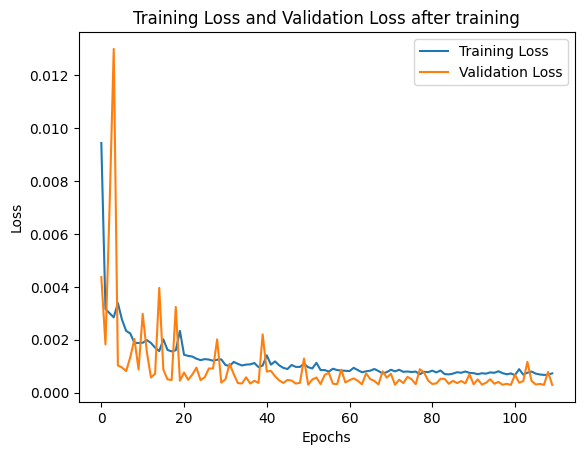

2/2 [==============================] - 0s 7ms/step
Training data root mean square error (RMSE): 1.229837425806187
Testing data root mean square error (RMSE): 1.1668959818843025
Training data Mean Absolute Error (MAE): 0.9172184561571866
Testing data Mean Absolute Error (MAE): 0.9484270105957027


In [35]:
stock_forecaster.graph_training_loss_validation_loss(lstm_predicted_stock)
trained_data_rmse_result, tested_data_rmse_result, trained_data_mae_result, tested_data_mae_result, train_actual, train_predicted, test_actual, test_predicted = stock_forecaster.rsme_mae()
print(f'Training data root mean square error (RMSE): {trained_data_rmse_result}')
print(f'Testing data root mean square error (RMSE): {tested_data_rmse_result}')
print(f'Training data Mean Absolute Error (MAE): {trained_data_mae_result}')
print(f'Testing data Mean Absolute Error (MAE): {tested_data_mae_result}')

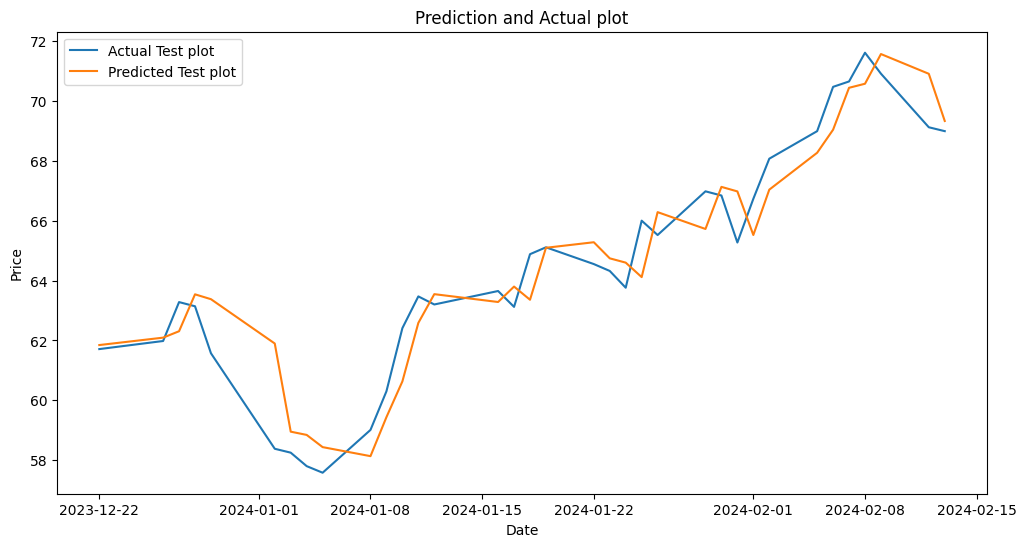

In [36]:
stock_forecaster.lstm_stock_market_forecasting_plot(test_actual, test_predicted)

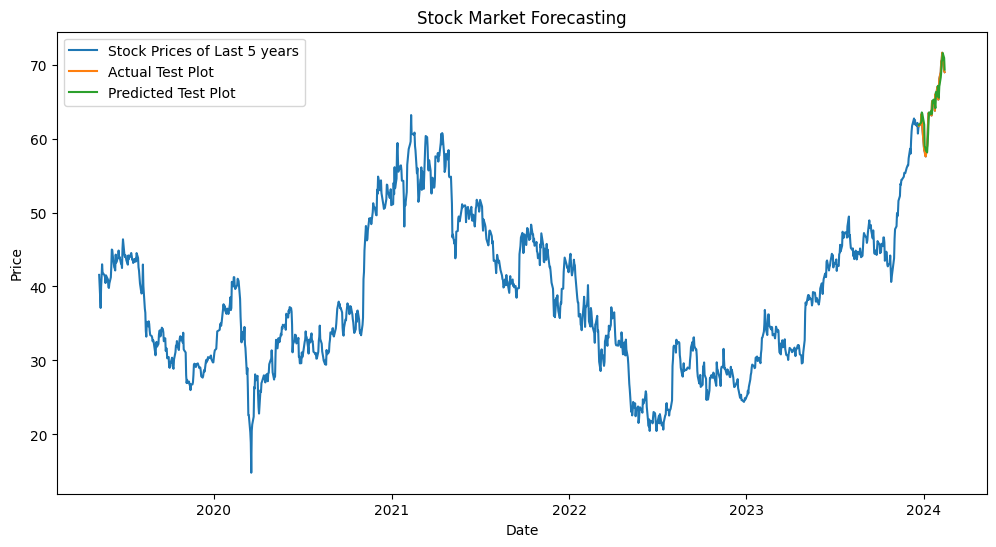

In [37]:
stock_forecaster.five_year_stock_price_plot(test_actual, test_predicted)